# Introduction
- This notebook presents Python code for the algorithm described in https://www.researchgate.net/publication/320864673_A_simple_algorithm_to_find_all_real_roots_of_a_polynomial. Please cite this paper if you use this code or part of it.
- The code finds all real roots of a polynomial, using standard floating point arithmetics.
- A companion notebook presents Python code for the same algorithm, using mpmath for arbitrary precision arithmetics.
- You may also read the *Fundamentals* notebook in this repository.
- This notebook contains code and tests using some notorious polynomials

# Code
Notes:
- Sympy polynomials and some associated functions are used only for the construction of polynomials for testing, and also for checking correctness of the number or roots found.

## Solver

In [1]:
def sign(value):
    if value < 0:
        return -1
    elif value == 0:
        return 0
    return 1

def degree(p):
    return len(p) - 1

def p_to_str(p):
    s = ''
    n = len(p) - 1
    for i in range(n):
        s = s + str(p[i]) + '*' + 'x**' + str(n-i) + ' + '
    s = s + str(p[n])
    return s

def derivative(p):
    n = len(p)
    return [p[i]*(n-i-1) for i in range(n-1)]

def evaluate(p, x_value):
    # Using Horner method
    result = p[0]
    for coef in p[1:]:
        result = result*x_value + coef
    return result

def bisection(a, b, tolerance, p, pdiff):
    '''
    Classical bisection method. 
    Raises ValueError when a no progress situation is detected
    pdiff parameter exists only to keep the same signature as other bracketing
    methods, such as Newton-Raphson, that uses the derivative of p
    '''    
    p_a = evaluate(p, a)
    p_b = evaluate(p, b)
    m = (a + b) / 2
    p_m = evaluate(p, m)
    progress = True
    
    iter = 0
    while abs(p_m) > tolerance and progress:
        iter += 1
        old_a, old_b = a, b
        if p_a * p_m <= 0:
            b = m
            p_b = p_m
        elif p_b * p_m <= 0:
            a = m
            p_a = p_m
        m = (a + b) / 2
        p_m = evaluate(p, m)
        if old_a == a and old_b == b:
            progress = False
            raise ValueError(f'bissection: no progress after {iter} iterations\n' 
                             f'while isolating a root of {p_to_str(p)} \nwith \na = {a} \nb = {b}')
    return m

def internal_root(p, pdiff, a, b, tolerance, bracketing):

    p_a = evaluate(p, a)
    if abs(p_a) <= tolerance:
        root_found = []
    else:
        p_b = evaluate(p, b)
        if abs(p_b) < tolerance:
            root_found = [b]
        else:
            sign_at_a = sign(p_a)
            sign_at_b = sign(p_b)
            if sign_at_a == sign_at_b:
                root_found = []
            else:
                root_found = [bracketing(a, b, tolerance, p, pdiff)]

    return root_found

def external_root(p, pdiff, extremity, limit_sign, initial_step, tolerance, bracketing):
    '''
    extremity is the smallest or largest root of pdiff.
    If initial_step < 0, this function will look for a root in interval (-inf, extremity];
    If initial_step > 0, this function will look for a root in interval (extremity, inf)
    '''
    def point_with_sign_inversion(p, extremity, sign_at_extremity, initial_step):

        #print(f'Looking for {p} sign inversion from x = {extremity} with initial step = {initial_step}')
        step = initial_step
        x = extremity + step
        p_x = evaluate(p, x)
        sign_at_x = sign(p_x)

        while sign_at_x == sign_at_extremity:
            step = 2*step # Double step length
            x = x + step
            p_x = evaluate(p, x)
            sign_at_x = sign(p_x)

        return x 

    value_at_extremity = evaluate(p, extremity)
    
    if abs(value_at_extremity) <= tolerance:
        if initial_step < 0:
            root_found = [extremity]
        else:
            root_found = []
    else:
        sign_at_extremity = sign(value_at_extremity)
        if limit_sign == sign_at_extremity:
            root_found = []
        else:
            if initial_step > 0:
                a = extremity
                b = point_with_sign_inversion(p, extremity, sign_at_extremity, initial_step)
            else:
                a = point_with_sign_inversion(p, extremity, sign_at_extremity, initial_step)
                b = extremity

            root_found = [bracketing(a, b, tolerance, p, pdiff)]
        
    return root_found

def roots_from_derivative_roots(p, derivative_roots, tolerance, bracketing):
    
    n_derivative_roots = len(derivative_roots)
    pdiff = derivative(p)

    roots = []
    
    if n_derivative_roots == 0:
        # I took 0, but any point should work
        left_extremity = 0
        right_extremity = 0
    else:
        left_extremity = derivative_roots[0]
        right_extremity = derivative_roots[-1]
    
    right_limit_sign = sign(p[0]) # p[0]: Leading Coefficient
       
    if degree(p) % 2 == 0:
        left_limit_sign = sign(p[0])
    else:
        left_limit_sign = -sign(p[0]) 
    
    roots = roots + external_root(p, pdiff, left_extremity, left_limit_sign, -1, 
                                  tolerance, bracketing)
    
    for i in range(n_derivative_roots - 1): 
        roots = roots + internal_root(p, pdiff, derivative_roots[i], derivative_roots[i+1], 
                                      tolerance, bracketing)
        
    roots = roots + external_root(p, pdiff, right_extremity, right_limit_sign, 1, 
                                  tolerance, bracketing)
    
    return roots    

def find_real_roots(p, tolerance=1.0e-5, bracketing=bisection):
    '''
     Find real roots of polynomial defined by list p
     If the length of p is n+1 then the polynomial is described by:
       p[0] * x**n + p[1] * x**(n-1) + ... + p[n-1]*x + p[n]
    '''

    # print(f'Solving {p_to_str(p)} = 0')

    if len(p) == 2: 
        # first degree polynomial
        roots = [-p[1]/p[0]]
    else:
        roots = roots_from_derivative_roots(p, 
                                            find_real_roots(derivative(p), tolerance, bracketing),
                                            tolerance, bracketing)

    # print(f'Roots of {p_to_str(p)}: {roots}')
    return roots

## Checking roots

In [2]:
from sympy import Symbol, Poly, rem, LC, Rational
from sympy import degree as sp_degree

x = Symbol('x')

def sign_at_minus_inf(poly):

    if sp_degree(poly) % 2 == 0:
        s = sign(LC(poly, x))
    else:
        s = sign(-LC(poly, x))
        
    return s
    
def sign_at_plus_inf(poly):

    s = sign(LC(poly, x))

    return s

In [3]:
def Sturm(p):
    """
    Returns total number of distinct real roots of p, based on Sturm's theorem
    https://en.wikipedia.org/wiki/Sturm%27s_theorem
    """
    x = Symbol('x')
    poly = Poly(p, x)
    
    minus_inf_sign_inversions = 0
    plus_inf_sign_inversions = 0
    
    last_p = poly.diff()

    if sign_at_minus_inf(poly) != sign_at_minus_inf(last_p):
        minus_inf_sign_inversions += 1
    if sign_at_plus_inf(poly) != sign_at_plus_inf(last_p):
        plus_inf_sign_inversions += 1
        
    last_sign_at_minus_inf = sign_at_minus_inf(last_p)
    last_sign_at_plus_inf = sign_at_plus_inf(last_p)

    while sp_degree(last_p) > 0:
        next_p = -rem(poly, last_p)

        if sign_at_minus_inf(next_p) != last_sign_at_minus_inf:
            minus_inf_sign_inversions += 1
        if sign_at_plus_inf(next_p) != last_sign_at_plus_inf:
            plus_inf_sign_inversions += 1
        poly = last_p
        last_p = next_p
        last_sign_at_minus_inf = sign_at_minus_inf(last_p)
        last_sign_at_plus_inf = sign_at_plus_inf(last_p)        
        
    return minus_inf_sign_inversions - plus_inf_sign_inversions

In [42]:
def check_roots(p, roots, tolerance):
    
    # Are all elements of roots distinct and in ascending order?
    for i in range(len(roots) - 1):
        if roots[i] >= roots[i + 1]:
            raise ValueError(f'roots[{i}] is >= roots[{i + 1}]')
    print(f'\ncheck_roots: all roots are distinct and in order')
    # For all r in roots, abs(p(r)) <= tolerance?

    for r in roots:
        if abs(evaluate(p, r)) > tolerance:
            raise ValueError(f'abs(p({r})) = {abs(evaluate(p, r))} > {tolerance}')
    print(f'check_roots: all roots are roots within tolerance')
    # Number of elements of roots equals Sturm(p)?
    n_roots_Sturm = Sturm(p)
    if len(roots) != n_roots_Sturm:
        raise ValueError(f"Only {len(roots)} real roots found; "
                         f"{n_roots_Sturm} real roots were expected by Sturm's theorem.")
    print(f"check_roots: number of real roots, {n_roots_Sturm},"
          " as expected by Sturm's theorem")

## Ploting polynomials

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_p(p, xlim):
    """
    Plots a polynomial
    """
    x_values = np.linspace(xlim[0], xlim[1], 200)
    #print(f'v = {v}')
    y_p = [evaluate(p, v) for v in x_values]
    
    ax = plt.gca()

    plt.gcf().text(0.02, -0.1, '$' + p_to_str(p) + '$', fontsize=11)
    

    ax.plot(x_values, y_p, 'b')

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    
    plt.show()

# Tests

## Polynomials with known roots
- Knowing the roots makes testing easier

In [7]:
def poly_from_roots(poly_roots, constant=Rational(1)):
    """
    Constructs a polynomial from a list of is roots. 
    If poly_roots contains a complex number, its conjugate will be included too.
    """
    x = Symbol('x')
    W = constant
    for r in poly_roots:
        if isinstance(r, complex):
            a = Rational(r.real)
            b = Rational(r.imag)
            W = W * (a**2 - 2*a*x + b**2 + x**2)
        else:
            W = W * (x - Rational(r))
    return [int(coef) for coef in Poly(W).all_coeffs()]

### A polynomial with 4 real roots

1*x**4 + -10*x**3 + 17*x**2 + 40*x**1 + -84


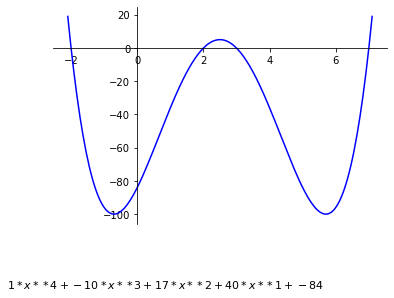

In [8]:
p = poly_from_roots([3, 2, -2, 7])
print(p_to_str(p))
plot_p(p, [-2.1, 7.1])

In [10]:
tolerance = 1.0e-7
roots = find_real_roots(p, tolerance=tolerance, bracketing=bisection)
roots

[-2.0, 1.9999999999999645, 3.0000000000000355, 7.0]

In [11]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 4, as expected by Sturm's theorem


### A polynomial with real  and complex roots

1*x**8 + -70*x**7 + 1126*x**6 + 25210*x**5 + -88631*x**4 + -1622840*x**3 + 4914444*x**2 + 6092480*x**1 + -18312000


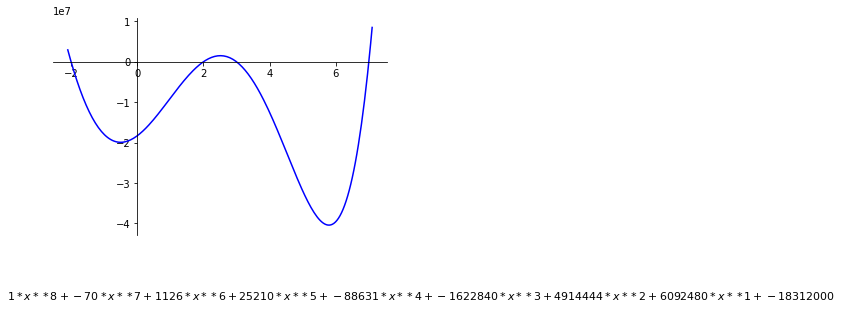

In [12]:
p = poly_from_roots([3, 2, -2, 7, 40 + 20j, -10 -3j])
print(p_to_str(p))
plot_p(p, [-2.1, 7.1])

In [13]:
tolerance = 1.0e-6
roots = find_real_roots(p, tolerance=tolerance, bracketing=bisection)
roots

[-2.0000000000000036, 1.9999999999999092, 2.999999999999938, 6.999999999999993]

In [14]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 4, as expected by Sturm's theorem


### A polynomial with only complex roots

1*x**8 + -20*x**7 + 200*x**6 + -1200*x**5 + 4708*x**4 + -12080*x**3 + 20000*x**2 + -19200*x**1 + 9216


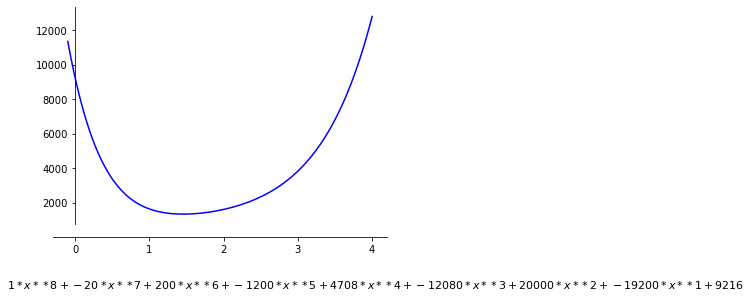

In [15]:
p = poly_from_roots([1 + 1j, 2 + 2j, 3 + 3j, 4 + 4j])
print(p_to_str(p))
plot_p(p, [-0.1, 4])

In [16]:
tolerance = 1.0e-6
roots = find_real_roots(p, tolerance=tolerance, bracketing=bisection)
roots

[]

In [17]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 0, as expected by Sturm's theorem


### A polynomial with roots with multiplicity

1*x**10 + -36*x**9 + 566*x**8 + -5100*x**7 + 29049*x**6 + -108792*x**5 + 269960*x**4 + -436032*x**3 + 436624*x**2 + -243840*x**1 + 57600


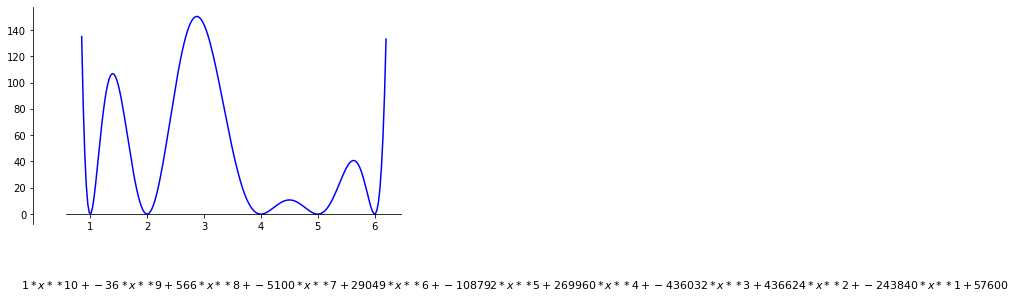

In [18]:
p = poly_from_roots([1]*2 + [2]*2 + [4, 5]*2 + [6]*2)
print(p_to_str(p))
plot_p(p, [0.85, 6.2])

In [19]:
tolerance = 1.0e-7
roots = find_real_roots(p, tolerance=tolerance, bracketing=bisection)
roots

[1.000000000013165,
 1.999999999923657,
 4.000000000274082,
 4.999999999940281,
 5.999999999963483]

In [20]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 5, as expected by Sturm's theorem


### Wilkinson polynomials

In [21]:
def Wilkinson(n):
    return poly_from_roots(list(range(1,n+1)))

1*x**10 + -55*x**9 + 1320*x**8 + -18150*x**7 + 157773*x**6 + -902055*x**5 + 3416930*x**4 + -8409500*x**3 + 12753576*x**2 + -10628640*x**1 + 3628800


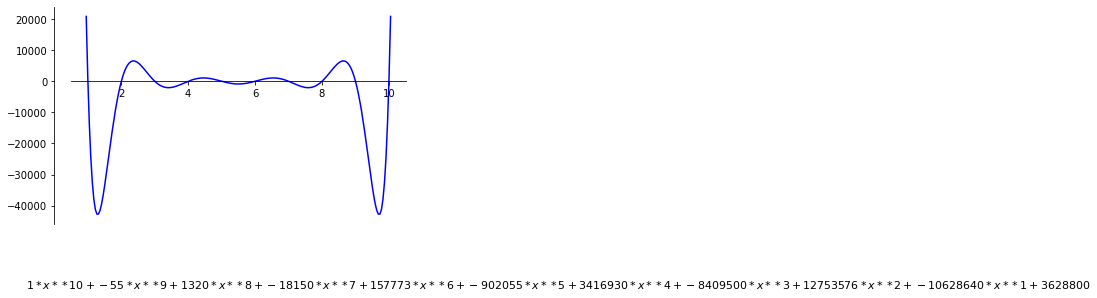

In [22]:
p = Wilkinson(10)
print(p_to_str(p))
plot_p(p, [0.95, 10.05])

In [24]:
tolerance = 1.0e-6
roots = find_real_roots(p, tolerance=tolerance)
roots

[1.0,
 1.9999999999946778,
 2.9999999999366196,
 3.999999999784545,
 5.000000000150992,
 5.999999999978906,
 7.00000000032061,
 7.9999999999897735,
 9.000000000144,
 10.000000000002046]

In [25]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 10, as expected by Sturm's theorem


In [26]:
# Same as above, but with a scricter tolerance that will raise a ValueException
tolerance = 1.0e-7 
roots = find_real_roots(p, tolerance=tolerance)
roots

ValueError: bissection: no progress after 50 iterations
while isolating a root of 5040*x**6 + -166320*x**5 + 2217600*x**4 + -15246000*x**3 + 56798280*x**2 + -108246600*x**1 + 82006320 
with 
a = 8.652204909629276 
b = 8.652204909629278

##  Mignotte polynomials

In [28]:
def Mignotte(n, tau):
    x = Symbol('x')
    return [int(coef) for coef in Poly((x**n - ((2**(tau//2) - 1)*x - 1)**2)).all_coeffs()]

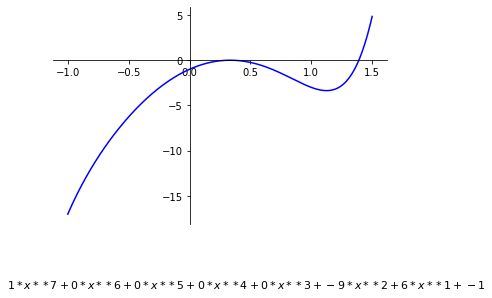

In [30]:
p = Mignotte(7, 4)
plot_p(p, (-1, 1.5))

In [31]:
tolerance = 1.0e-10
roots = find_real_roots(p, tolerance=tolerance)
roots

[0.3266904546526348, 0.34105602610169483, 1.3907436473218695]

In [32]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 3, as expected by Sturm's theorem


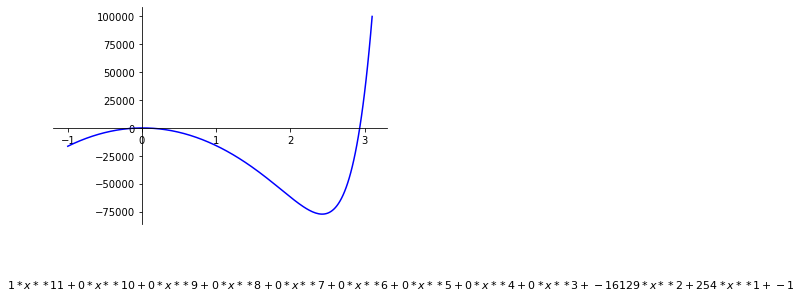

In [35]:
p = Mignotte(11, 14)
plot_p(p, (-1, 3.1))

In [36]:
tolerance = 1.0e-10
roots = find_real_roots(p, tolerance=tolerance)
roots

[0.007874015748033703, 2.932597504867591]

In [43]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance


ValueError: Only 2 real roots found; 3 real roots were expected by Sturm's theorem.

## Chebyshev polynomials of first kind

In [44]:
def memoize(f):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = f(x)
        return memo[x]
    return helper

@memoize
def Chebyshev(n):
    x = Symbol('x')
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return (2*x*Chebyshev(n-1) - Chebyshev(n-2)).expand()

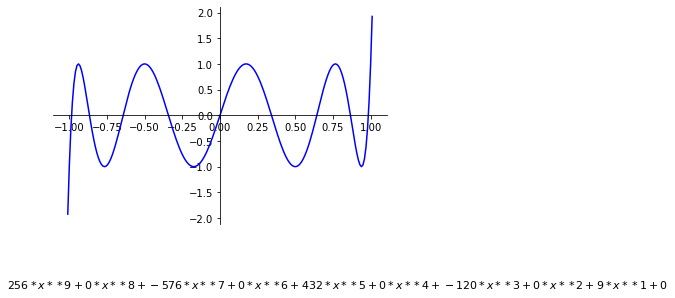

[-0.9848076112684794,
 -0.8660254330571593,
 -0.6427873954302028,
 -0.34202041128977234,
 0.0,
 0.34202041128977234,
 0.6427873954302028,
 0.8660254330571593,
 0.9848076112684794]

In [45]:
p = [int(coef) for coef in Poly(Chebyshev(9)).all_coeffs()]
plot_p(p, (-1.01, 1.01))
tolerance = 1.0e-5
roots = find_real_roots(p, tolerance=tolerance)
roots

In [46]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 9, as expected by Sturm's theorem
